<a href="https://colab.research.google.com/github/hertie-data-science-lab/assignment-2-ps-2-b/blob/added-by-elena/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem set 2

## Team
Please write here your names and team number.

* Team name: Team PS 2 B
* Team members: Nadine Daum (245963), Nicolas Reichardt (245611), Elena Murray (239793)

## AI use statement:
Generative AI tools (e.g., ChatGPT-5, GitHub Copilot, Claude, and DeepL for translation) were consulted for proofreading, LaTeX formatting, and general optimization support. All final answers were developed + verified by the authors.

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [78]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 23037 with label: 8


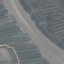

In [79]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

In [80]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Create class rotate:
class rotate:

  valid_rotations = [90, 180, 270, 360]

  def __init__(self, rotation):
    if rotation not in self.valid_rotations:
      raise ValueError(
                f"Invalid rotation angle: {rotation}°."
                f"Valid rotations are: {self.valid_rotations}")
    self.k = rotation // 90
    self.rotation = rotation

  def __call__(self, pic):
    if isinstance(pic, Image.Image):
      pic = np.array(pic) # PIL → NumPy
    elif not isinstance(pic, np.ndarray):
      raise TypeError(f"Unsupported image type: {type(pic)}")

    rotated = np.rot90(pic, self.k)

    return Image.fromarray(rotated) # NumPy → PIL

new_pic = rotate(90)(pic) # Example of rotating a picture by 90 degrees
same_pic = rotate(360)(pic) # Example of rotating a picture by 360 degrees (should return the same picture)



Text(0.5, 1.0, 'Rotated by 360°')

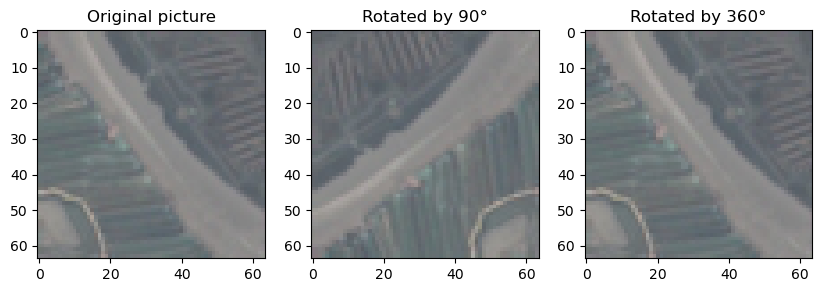

In [81]:
#Test
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

/var/folders/fk/jrs5sj2165v98_klcg800pk40000gn/T/ipykernel_75316/274879550.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


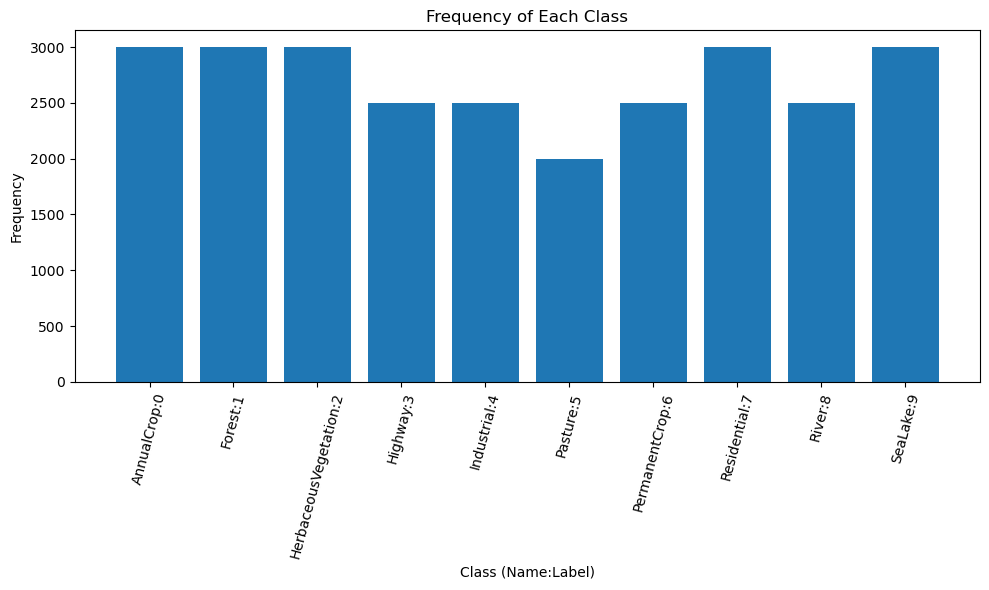

In [82]:
from collections import Counter

#Plot a histogram:
def plot_histogram(data):

  #First count class labels
  labels = [label for _, label in data]
  label_counts = Counter(labels)

  #Get label names from dataset
  class_names = data.classes

  # Create x and y labels
  x_labels = [f"{class_names[i]}:{i}" for i in label_counts.keys()]
  y_values = [label_counts[i] for i in label_counts.keys()]

  #Plot
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(x_labels, y_values)
  ax.set_title("Frequency of Each Class")
  ax.set_xlabel("Class (Name:Label)")
  ax.set_ylabel("Frequency")
  ax.tick_params(axis='x', rotation=75)
  fig.tight_layout()

  return fig, ax


fig, ax = plot_histogram(data)
fig.show()

In [83]:
import random
from torchvision import transforms

#Create RotateEuroSAT class:

class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data:Dataset,
                 length:int,
                 shares:list,
                 device=None,
                 seed=42):

        self.original_data = original_data
        self.length = length
        assert np.isclose(sum(shares), 1.0), f"Shares must sum to 1 (got {sum(shares)})" #change to np.isclose to avoid floating point issues
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label

    def _create_rotated_dataset(self):

        #Set seed for reproducibility
        random.seed(self.seed)
        torch.manual_seed(self.seed)

        # Transform to tensors
        to_tensor = transforms.ToTensor()

        # Count how many samples per class to create
        n_classes = len(self.original_data.classes)
        class_counts = [int(self.length * share) for share in self.shares]

        dataset = []

        # For each class, sample images and apply random rotations
        for class_idx, n_samples in enumerate(class_counts):
            # Get all indices for this class
            class_indices = [i for i, (_, label) in enumerate(self.original_data) if label == class_idx]

            for _ in range(n_samples):
                # Pick a random image from this class
                img_idx = random.choice(class_indices)
                img, label = self.original_data[img_idx]

                # Apply a random rotation:
                angle = random.choice([90, 180, 270, 360])
                rotated_img = rotate(angle)(img) #use the rotate class from before

                # Convert to tensor
                img_tensor = to_tensor(rotated_img)

                # Move to GPU if specified
                if self.device:
                    img_tensor = img_tensor.to(self.device)

                dataset.append((img_tensor, label))

        return dataset


In [84]:
rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             seed=42)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [85]:
import torch
import torch.nn as nn

# Create MyMaxPool:

class MyMaxPool(nn.Module): # use nn.Module instead of nn.Sequential to make it simpler
    def __init__(self, kernel_size, stride=None):
        super().__init__()
        self.k = kernel_size
        self.s = stride or kernel_size

    def forward(self, x):
        B, C, H, W = x.shape
        x_unfold = x.unfold(2, self.k, self.s).unfold(3, self.k, self.s)
        x_pooled = x_unfold.contiguous().view(B, C, x_unfold.shape[2], x_unfold.shape[3], -1)
        return x_pooled.max(dim=-1)[0]

In [86]:
# Small test to see how it's working:
x = torch.arange(1, 17).float().reshape(1, 1, 4, 4)

pool = MyMaxPool(kernel_size=2, stride=2)
out = pool(x)

print("Input:\n", x[0,0])
print("Output after pooling:\n", out[0,0])

Input:
 tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])
Output after pooling:
 tensor([[ 6.,  8.],
        [14., 16.]])


So, this max pooling layer is customisable and allows us to input and decide the kernel size and stride size before we apply it.

In [125]:
class MyCNNModel(nn.Sequential):
    def __init__(self, n_classes):
        super().__init__(
            # Conv Layer 1 (k = 3)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 3x64x64 → 32x64x64
            nn.ReLU(),

            # Conv Layer 2 (k = 5)
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # 32x64x64 → 64x64x64
            nn.ReLU(),

            # Apply Max Pooling (k = 2, s = 2)
            MyMaxPool(kernel_size=2, stride=2),           # 64x64x64 → 64x32x32

            # Conv Layer 3 (k = 3)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64x32x32 → 128x32x32
            nn.ReLU(),

            # Apply Max Pooling (k = 2, s = 2)
            MyMaxPool(kernel_size=2, stride=2),           # 128x32x32 → 128x16x16

            # Flatten
            nn.Flatten(),                                 # → 128×16×16 = 32768
            nn.Linear(128 * 16 * 16, 256),               
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        return super().forward(x)

In [129]:
#print one iteration of your model to test its correctness

my_model = MyCNNModel(n_classes=10) #change to 10 classes
X, y = train_data[0]
output = my_model(X[None, :])
predicted = output.argmax(dim=1).item()  # Get predicted class

probs = torch.softmax(output, dim=1)

print("Class probabilities:", probs)
print("Predicted:", predicted)
print("True label:", y)

Class probabilities: tensor([[0.0961, 0.1065, 0.1010, 0.0997, 0.0957, 0.0976, 0.1011, 0.1054, 0.1014,
         0.0953]], grad_fn=<SoftmaxBackward0>)
Predicted: 1
True label: 7


This model architecture contains three convolutional layers with ReLU activations, two max pooling layers to reduce spatial dimensions, and two fully connected layers. The output layer uses Softmax activation for multi-class classification. The convolutional layers are used to detect and learn features such as edges and textures, and the max pooling step is used twice in order to reduce the spatial dimensions and therefore make it less computationally demanding while preserving key features. The fully connected layers at the end are used to interepet the learned feature maps and then classify probabilities accordingly. The model was kept as minimal and simple as possible to assist with faster computation on cpu (we ran out of the free gpu). 

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [130]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc



  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:0 - Avg loss:1.60601 - Avg acc:0.40587: 100%|██████████| 125/125 [06:59<00:00,  3.36s/it]


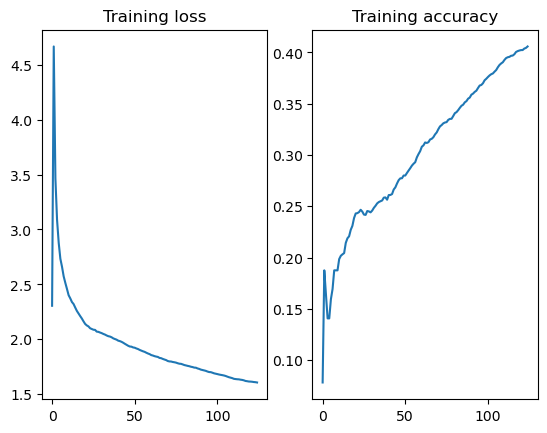

In [131]:
# train your model

#set up trainer
my_trainer = Trainer(my_model, cfg)

#train model
train_loss_1, train_acc_1 = my_trainer.train(train_data)

# plot accuracy and loss by iteration (one iteration=one batch)

#plot training loss and accuracy per iteration
fig, (ax0, ax1) = plt.subplots(1,2)

#plot
ax0.plot(range(len(train_loss_1)), train_loss_1)
ax1.plot(range(len(train_acc_1)), train_acc_1)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

plt.show()


Text(0.5, 1.0, 'Test accuracy')

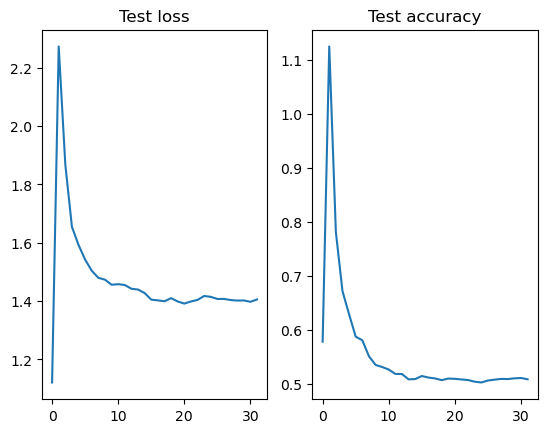

In [132]:
# test your model

#test model
test_loss_1, test_acc_1 = my_trainer.test(test_data)

# plot accuracy and loss by iteration (one iteration=one batch)

#plot test loss and accuracy per iteration
fig, (ax0, ax1) = plt.subplots(1,2)

#plot
ax0.plot(range(len(test_loss_1)), test_loss_1)
ax1.plot(range(len(test_acc_1)), test_acc_1)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')



### Interpretation: 

The test accuracy graph shows values exceeding 1.0, which is incorrect since accuracy should always be between 0 and 1. Also, the accuracy appears to decrease over batches — test accuracy should generally remain stable or slightly improve.

This suggests a potential issue in how test accuracy is being calculated in the Trainer class. However, as per the instructions, this code was left unchanged.




## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [139]:
#grid search:

def grid_search(model_class, train_data, test_data, learning_rates, batch_sizes, cfg):
    best_model = None
    best_cfg = None
    best_train_loss, best_train_acc = float('inf'), 0
    best_test_loss, best_test_acc = float('inf'), 0

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing with learning rate: {lr}, batch size: {batch_size}")
            cfg['learning_rate'] = lr
            cfg['batch_size'] = batch_size

            # Initialize model and trainer
            model = model_class(n_classes=len(data.classes))
            trainer = Trainer(model, cfg)

            # Train and test the model
            train_loss, train_acc = trainer.train(train_data)
            test_loss, test_acc = trainer.test(test_data)

            # Evaluate performance
            if test_acc[-1] > best_test_acc or (test_acc[-1] == best_test_acc and test_loss[-1] < best_test_loss):
                best_model = model
                best_cfg = cfg.copy()
                best_train_loss, best_train_acc = train_loss[-1], train_acc[-1]
                best_test_loss, best_test_acc = test_loss[-1], test_acc[-1]

    return best_model, best_cfg, best_train_loss, best_train_acc, best_test_loss, best_test_acc

learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]
best_model, best_cfg, best_train_loss, best_train_acc, best_test_loss, best_test_acc = grid_search(
    MyCNNModel, train_data, test_data, learning_rates, batch_sizes, cfg
)

print("Best Configuration:", best_cfg)
print(f"Train Loss: {best_train_loss}, Train Accuracy: {best_train_acc}")
print(f"Test Loss: {best_test_loss}, Test Accuracy: {best_test_acc}")



Testing with learning rate: 0.001, batch size: 32


Epoch:0 - Avg loss:1.55196 - Avg acc:0.41905: 100%|██████████| 250/250 [05:31<00:00,  1.32s/it]


Testing with learning rate: 0.001, batch size: 64


Epoch:0 - Avg loss:1.64108 - Avg acc:0.38344: 100%|██████████| 125/125 [05:04<00:00,  2.44s/it]


Testing with learning rate: 0.001, batch size: 128


Epoch:0 - Avg loss:1.74395 - Avg acc:0.36895: 100%|██████████| 63/63 [04:55<00:00,  4.69s/it]


Testing with learning rate: 0.0005, batch size: 32


Epoch:0 - Avg loss:1.55672 - Avg acc:0.42118: 100%|██████████| 250/250 [05:30<00:00,  1.32s/it]


Testing with learning rate: 0.0005, batch size: 64


Epoch:0 - Avg loss:1.64150 - Avg acc:0.39352: 100%|██████████| 125/125 [04:54<00:00,  2.35s/it]


Testing with learning rate: 0.0005, batch size: 128


Epoch:0 - Avg loss:1.77298 - Avg acc:0.35282: 100%|██████████| 63/63 [04:52<00:00,  4.64s/it]


Testing with learning rate: 0.0001, batch size: 32


Epoch:0 - Avg loss:1.74140 - Avg acc:0.35166: 100%|██████████| 250/250 [05:21<00:00,  1.28s/it]


Testing with learning rate: 0.0001, batch size: 64


Epoch:0 - Avg loss:1.88427 - Avg acc:0.30091: 100%|██████████| 125/125 [05:19<00:00,  2.56s/it]


Testing with learning rate: 0.0001, batch size: 128


Epoch:0 - Avg loss:2.04509 - Avg acc:0.24042: 100%|██████████| 63/63 [05:00<00:00,  4.77s/it]


Best Configuration: {'batch_size': 32, 'criterion': 'CrossEntropyLoss', 'epochs': 1, 'learning_rate': 0.001, 'optimizer': 'Adam', 'seed': 42}
Train Loss: 1.551961812867697, Train Accuracy: 0.4190512048192771
Test Loss: 1.085595074199861, Test Accuracy: 0.6421371102333069


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [133]:
#TODO: import and fine-tune a pretrained model
#Load resnet18 from timm 

import timm

#load model
loaded_model = timm.create_model('resnet18', pretrained=True)

# replace final classification layer to match EuroSAT dataset
num_classes = 10  # EuroSAT has 10 classes
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, num_classes)

#Load trainer
loaded_trainer = Trainer(loaded_model, cfg)


Epoch:0 - Avg loss:0.65029 - Avg acc:0.80431: 100%|██████████| 125/125 [06:44<00:00,  3.23s/it]


Text(0.5, 1.0, 'Training accuracy')

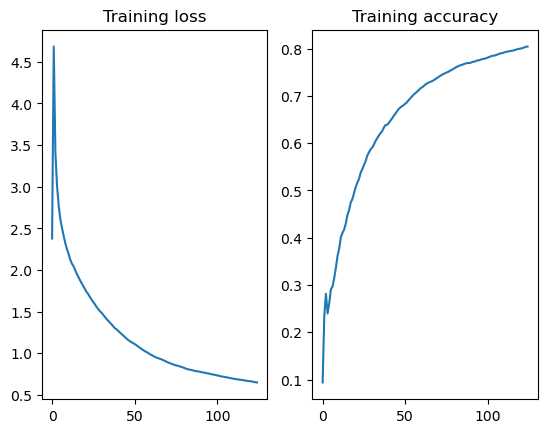

In [134]:
#train your model, plot accuracy and loss by iteration (one iteration=one batch)
train_loss_2, train_acc_2 = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss_2)), train_loss_2)
ax1.plot(range(len(train_acc_2)), train_acc_2)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')


Text(0.5, 1.0, 'Test accuracy')

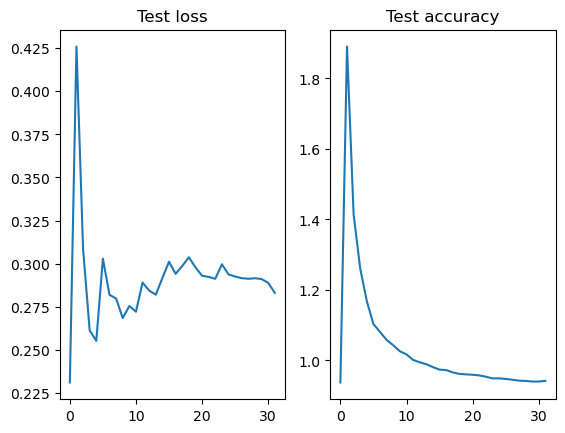

In [135]:
#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)
test_loss_2, test_acc_2 = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss_2)), test_loss_2)
ax1.plot(range(len(test_acc_2)), test_acc_2)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')



Interpretation: the test accuracy graph is subject to the same issues discussed above for the custom CNN model. 

ResNet-18 was chosen as it is one of the most widely used CNN models in computer vision applications (as discussed in the lab for Week 5, where we also used this architecture to fine-tune an image classification model). ResNet-18 consists of 18 layers, including convolutional layers, ReLU activations, and fully connected layers. It also utilises residual connections, which allow the network to learn residuals, or differences, between the input and output. This model is known to be particularly useful when working with constrained computational resources (as is the case for this problem set), while still achieving strong results and accuracy.

<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).
| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |      
             





In [137]:
from jinja2 import Template
from IPython.display import Markdown, display

# Markdown table template using your variable names
template = Template("""
| Test metric         | Model 1 (custom CNN) | Model 2 (fine tuned from ResNet 18) |
|---------------------|----------------|----------------|
| Accuracy (train)    | **{{ train_acc_1 }}** | **{{ train_acc_2 }}** |
| Loss (train)        | **{{ train_loss_1 }}** | **{{ train_loss_2 }}** |
| Accuracy (test)     | **{{ test_acc_1 }}** | **{{ test_acc_2 }}** |
| Loss (test)         | **{{ test_loss_1 }}** | **{{ test_loss_2 }}** |
""")

# Format function to ensure 4 decimal points
def _fmt(x):
    return f"{float(x):.4f}"

# Display the table with the latest values (e.g., from training/testing lists)
display(Markdown(template.render(
    train_loss_1=_fmt(train_loss_1[-1]),
    train_acc_1=_fmt(train_acc_1[-1]),
    test_loss_1=_fmt(test_loss_1[-1]),
    test_acc_1=_fmt(test_acc_1[-1]),

    train_loss_2=_fmt(train_loss_2[-1]),
    train_acc_2=_fmt(train_acc_2[-1]),
    test_loss_2=_fmt(test_loss_2[-1]),
    test_acc_2=_fmt(test_acc_2[-1]),
)))


| Test metric         | Model 1 (custom CNN) | Model 2 (fine tuned from ResNet 18) |
|---------------------|----------------|----------------|
| Accuracy (train)    | **0.4059** | **0.8043** |
| Loss (train)        | **1.6060** | **0.6503** |
| Accuracy (test)     | **0.5086** | **0.9420** |
| Loss (test)         | **1.4056** | **0.2830** |

Interpretation:

Model 2 (ie. the model fine tuned with ResNet18) does much better over 1 epoch than our custom CNN model in both training and test data.

In the training set, the custom model reaches only 40% accuracy, whereas the ResNet model reaches 80%, meaning it learns faster and with higher accuracy. For the test set, ResNet achieves 94% accuracy, whereas our custom model reaches only 50%.

This is to be expected as ResNet is a deeper pre-trained model that has learned features from a large dataset and has been constructed with an architecture that has been widely validated. Fine-tuning the model uses the features that have already been learned and adapts them to the EuroSAT data. Whereas, the custom model is much simpler and starts with random weights, so in one training epoch it has not had enough time to learn strong features.